In [1]:
from kepler.pandas.menu       import ElectronSequence as Chain
from kepler.pandas.readers    import load, load_in_loop
from kepler.pandas.decorators import RingerDecorator
from collections import defaultdict
from typing import List

import kepler
from itertools import product
import rootplotlib as rpl
import mplhep as hep
import root_numpy
import ROOT
ROOT.gStyle.SetOptStat(0);
import array

import numpy as np
import pandas as pd
import collections
import glob
import os
from pprint import pprint
from copy import deepcopy
import gc
import logging
from datetime import datetime


import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import mplhep as hep

import warnings
warnings.filterwarnings('ignore')
plt.style.use(hep.style.ROOT)

from packages.generators import ring_percentages, RingGenerator
from packages.plotting import make_plot_fig

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


In [2]:
drop_cols = drop_columns = [
                    'RunNumber', 
                    'trig_L2_cl_e2tsts1',
                    'trig_L2_el_hastrack',
                    'trig_L2_el_eta',
                    'trig_L2_el_phi',
                    'trig_L2_el_caloEta',
                    'trig_L2_el_trkClusDeta',
                    'trig_L2_el_trkClusDphi',
                    'trig_L2_el_etOverPt',
                    'trig_EF_cl_hascluster',
                    'trig_EF_cl_eta',
                    'trig_EF_cl_etaBE2',
                    'trig_EF_cl_phi',     
                    'trig_EF_el_hascand',
                    'trig_EF_el_eta',
                    'trig_EF_el_etaBE2',
                    'trig_EF_el_phi',
                    'trig_EF_el_rhad1',
                    'trig_EF_el_rhad',
                    'trig_EF_el_f3',
                    'trig_EF_el_weta2',
                    'trig_EF_el_rphi',
                    'trig_EF_el_reta',
                    'trig_EF_el_wtots1',
                    'trig_EF_el_eratio',
                    'trig_EF_el_f1',
                    'trig_EF_el_hastrack',
                    'trig_EF_el_deltaEta1',
                    'trig_EF_el_deltaPhi2',
                    'trig_EF_el_deltaPhi2Rescaled',
                    'el_etaBE2',
                    'el_numberOfBLayerHits',
                    'el_numberOfPixelHits',
                    'el_numberOfTRTHits',
                    'el_trans_TRT_PID',
                    'el_deltaPhi2',
                    'el_TaP_Mass',
                ]

base_chain_names = [
     'e24_lhtight_nod0_{strategy}_ivarloose',
     'e26_lhtight_nod0_{strategy}_ivarloose',
     'e60_lhmedium_nod0_{strategy}_L1EM24VHI',
     'e140_lhloose_nod0_{strategy}'
]

trigger_steps = ['L2Calo', 'L2', 'EFCalo', 'HLT']

# boosted_chains = [
#     "HLT_e24_lhtight_nod0_{strategy}_v20_ivarloose",
#     "HLT_e26_lhtight_nod0_{strategy}_ivarloose",,
#     "HLT_e60_lhmedium_nod0_{strategy}_L1EM24VHI",
#     "HLT_e140_lhloose_nod0_{strategy}"
# ]

l1seeds_per_energy = {
    24: 'L1_EM22VHI',
    26: 'L1_EM22VHI',
    60: 'L1_EM24VHI',
    140: 'L1_EM24VHI'
}

conf_names = [
    'ElectronRingerLooseTriggerConfig.conf',
    'ElectronRingerMediumTriggerConfig.conf',
    'ElectronRingerTightTriggerConfig.conf',
    'ElectronRingerVeryLooseTriggerConfig.conf'
]

criteria = ['tight', 'medium', 'loose', 'vloose']

# plot_vars = ['et', 'eta', 'pt', 'mu']

In [3]:
def get_logger():
    logger = logging.getLogger('analysis_logger')
    logger.setLevel(logging.INFO)
    now = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
    log_filename = f'run_analysis_{now}'
    #file_handler = logging.FileHandler(log_filename, mode='w')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    #file_handler.setFormatter(formatter)
    #logger.addHandler(file_handler)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    return logger

analysis_logger = get_logger()

In [4]:
modelpaths = [
    'tunings/TrigL2_20180125_v8',
    'tunings/TrigL2_20210907_v12 (v8.1-2)',
    'tunings/TrigL2_20220704_v20',
    'tunings/TrigL2_20220802_v20.1'
]

In [5]:
analysis_logger.info('Building decorators')
decorators = list()
trigger_strategies = list()
for modelpath, conf_criterion in product(modelpaths, zip(conf_names, criteria)):
    conf_name, criterion = conf_criterion
    confpath = os.path.join(modelpath, conf_name)
    env = ROOT.TEnv(confpath)
    ringer_version = env.GetValue("__version__", '')
    ringer_name = f'ringer_{ringer_version}'
    analysis_logger.info(f'Building decorator for {confpath}. Version: {ringer_version}')
    decorator = RingerDecorator(f'{ringer_name}_{criterion}', confpath, RingGenerator(ring_percentages[ringer_version]))
    decorators.append(decorator)
    if not ringer_name in trigger_strategies:
        trigger_strategies.append(ringer_name)

2022-08-16 18:00:02,458 - Building decorators
2022-08-16 18:00:02,462 - Building decorator for tunings/TrigL2_20180125_v8/ElectronRingerLooseTriggerConfig.conf. Version: v8
2022-08-16 18:00:02,750 - Building decorator for tunings/TrigL2_20180125_v8/ElectronRingerMediumTriggerConfig.conf. Version: v8
2022-08-16 18:00:02,998 - Building decorator for tunings/TrigL2_20180125_v8/ElectronRingerTightTriggerConfig.conf. Version: v8
2022-08-16 18:00:03,245 - Building decorator for tunings/TrigL2_20180125_v8/ElectronRingerVeryLooseTriggerConfig.conf. Version: v8
2022-08-16 18:00:03,493 - Building decorator for tunings/TrigL2_20210907_v12 (v8.1-2)/ElectronRingerLooseTriggerConfig.conf. Version: v12
2022-08-16 18:00:03,737 - Building decorator for tunings/TrigL2_20210907_v12 (v8.1-2)/ElectronRingerMediumTriggerConfig.conf. Version: v12
2022-08-16 18:00:03,979 - Building decorator for tunings/TrigL2_20210907_v12 (v8.1-2)/ElectronRingerTightTriggerConfig.conf. Version: v12
2022-08-16 18:00:04,277 - 

2022-08-16 18:00:02,462 | Py.RingerDecorator                      INFO Reading... tunings/TrigL2_20180125_v8/ElectronRingerLooseTriggerConfig.conf
2022-08-16 18:00:02,751 | Py.RingerDecorator                      INFO Reading... tunings/TrigL2_20180125_v8/ElectronRingerMediumTriggerConfig.conf
2022-08-16 18:00:02,998 | Py.RingerDecorator                      INFO Reading... tunings/TrigL2_20180125_v8/ElectronRingerTightTriggerConfig.conf
2022-08-16 18:00:03,246 | Py.RingerDecorator                      INFO Reading... tunings/TrigL2_20180125_v8/ElectronRingerVeryLooseTriggerConfig.conf
2022-08-16 18:00:03,494 | Py.RingerDecorator                      INFO Reading... tunings/TrigL2_20210907_v12 (v8.1-2)/ElectronRingerLooseTriggerConfig.conf
2022-08-16 18:00:03,737 | Py.RingerDecorator                      INFO Reading... tunings/TrigL2_20210907_v12 (v8.1-2)/ElectronRingerMediumTriggerConfig.conf
2022-08-16 18:00:03,979 | Py.RingerDecorator                      INFO Reading... tunings/Tr

2022-08-16 18:00:02.469518: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-16 18:00:02.469538: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: UNKNOWN ERROR (-1)
2022-08-16 18:00:02.469549: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: caloba23
2022-08-16 18:00:02.469553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: caloba23
2022-08-16 18:00:02.469606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: Not found: was unable to find libcuda.so DSO loaded into this program
2022-08-16 18:00:02.469630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.74.0
2022-08-16 18:00:02.469753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use th

In [6]:
chain_names = base_chain_names.copy()

In [7]:
analysis_logger.info('Building chains')
chains = list()
step_chain_names = list()
for chain_name, strategy in product(chain_names, trigger_strategies):
    spliited_chain_name = chain_name.split('_')
    criterion = spliited_chain_name[1].replace('lh', '')
    step_chain_name = f'HLT_{chain_name.format(strategy=strategy)}'
    step_chain_names.append(step_chain_name)
    energy = int(spliited_chain_name[0][1:])
    l1seed = l1seeds_per_energy[energy]
    l2calo_column = f'{strategy}_{criterion}'
    analysis_logger.info(f'Building chain: {step_chain_name}')
    chain = Chain(step_chain_name, L1Seed=l1seed, l2calo_column=l2calo_column)
    chains.append(chain)

2022-08-16 18:00:11,135 - Building chains
2022-08-16 18:00:11,136 - Building chain: HLT_e24_lhtight_nod0_ringer_v8_ivarloose
2022-08-16 18:00:11,136 - Building chain: HLT_e24_lhtight_nod0_ringer_v12_ivarloose
2022-08-16 18:00:11,137 - Building chain: HLT_e24_lhtight_nod0_ringer_v20_ivarloose
2022-08-16 18:00:11,137 - Building chain: HLT_e24_lhtight_nod0_ringer_v20.1_ivarloose
2022-08-16 18:00:11,137 - Building chain: HLT_e26_lhtight_nod0_ringer_v8_ivarloose
2022-08-16 18:00:11,138 - Building chain: HLT_e26_lhtight_nod0_ringer_v12_ivarloose
2022-08-16 18:00:11,138 - Building chain: HLT_e26_lhtight_nod0_ringer_v20_ivarloose
2022-08-16 18:00:11,138 - Building chain: HLT_e26_lhtight_nod0_ringer_v20.1_ivarloose
2022-08-16 18:00:11,139 - Building chain: HLT_e60_lhmedium_nod0_ringer_v8_L1EM24VHI
2022-08-16 18:00:11,139 - Building chain: HLT_e60_lhmedium_nod0_ringer_v12_L1EM24VHI
2022-08-16 18:00:11,139 - Building chain: HLT_e60_lhmedium_nod0_ringer_v20_L1EM24VHI
2022-08-16 18:00:11,140 - Buil

OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v8_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v12_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v20_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1_EM22VHI'),
             ('L2Calo', (21000.0, 'ringer_v20.1_tight')),
             ('L2', 'trig_L2_el_cut_pt20to50'),
             ('EFCalo', 24000.0),
             ('HLT', (24000.0, 'trig_EF_el_lhtight_ivarloose'))])
OrderedDict([('L1Seed', 'L1

In [8]:
datasetpath = '/home/lbarranunes/data/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins'
dev = True

In [9]:
analysis_logger.info('Loading the data')
filename_end = '*et4_eta0.npz' if dev else '*.npz'
datafiles = glob.glob(os.path.join(datasetpath, filename_end))  
data = load_in_loop(datafiles, drop_columns=drop_cols, decorators=decorators, chains=chains)

2022-08-16 18:00:11,152 - Loading the data
Reading files...:   0%|          | 0/1 [00:00<?, ?it/s]

L1_EM22VHI ringer_v8_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v12_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v20_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v20.1_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v8_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v12_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v20_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM22VHI ringer_v20.1_tight trig_L2_el_cut_pt20to50 trig_EF_el_lhtight_ivarloose
L1_EM24VHI ringer_v8_medium trig_L2_el_cut_pt50toInf trig_EF_el_lhmedium
L1_EM24VHI ringer_v12_medium trig_L2_el_cut_pt50toInf trig_EF_el_lhmedium
L1_EM24VHI ringer_v20_medium trig_L2_el_cut_pt50toInf trig_EF_el_lhmedium
L1_EM24VHI ringer_v20.1_medium trig_L2_el_cut_pt50toInf trig_EF_el_lhmedium
L1_EM24VHI ringer_v8_loose trig_L2_el_cut_pt50toInf t

Reading files...: 100%|██████████| 1/1 [03:52<00:00, 232.98s/it]


In [10]:
data.columns

Index(['avgmu', 'trig_L2_cl_et', 'trig_L2_cl_eta', 'trig_L2_cl_phi',
       'trig_L2_cl_reta', 'trig_L2_cl_ehad1', 'trig_L2_cl_eratio',
       'trig_L2_cl_f1', 'trig_L2_cl_f3', 'trig_L2_cl_weta2',
       ...
       'L1Calo_e140_lhloose_nod0_ringer_v20',
       'L2Calo_e140_lhloose_nod0_ringer_v20',
       'L2_e140_lhloose_nod0_ringer_v20',
       'EFCalo_e140_lhloose_nod0_ringer_v20',
       'HLT_e140_lhloose_nod0_ringer_v20',
       'L1Calo_e140_lhloose_nod0_ringer_v20.1',
       'L2Calo_e140_lhloose_nod0_ringer_v20.1',
       'L2_e140_lhloose_nod0_ringer_v20.1',
       'EFCalo_e140_lhloose_nod0_ringer_v20.1',
       'HLT_e140_lhloose_nod0_ringer_v20.1'],
      dtype='object', length=291)

In [11]:
plot_vars = ['et']
output_dir = 'analysis_out'

In [12]:
analysis_logger.info('Making plots')
figs = dict()
labels = dict()
for fake, step, chain_name, var in product([True, False], trigger_steps, chain_names, plot_vars):
    value_name = 'fr' if fake else 'pd'
    plot_dir = os.path.join(output_dir, value_name, var)
    analysis_logger.info(f'Plotting value:{value_name}, step: {step}, chain_name: {chain_name}, var: {var}')
    plot_name, fig, label = make_plot_fig(data, step, chain_name, trigger_strategies, plot_dir , var, fake)
    figs[plot_name] = fig
    labels[plot_name] = label

2022-08-16 18:04:06,600 - Making plots
2022-08-16 18:04:06,600 - Plotting value:fr, step: L2Calo, chain_name: e24_lhtight_nod0_{strategy}_ivarloose, var: et
2022-08-16 18:04:13,626 - Plotting value:fr, step: L2Calo, chain_name: e26_lhtight_nod0_{strategy}_ivarloose, var: et
2022-08-16 18:04:19,080 - Plotting value:fr, step: L2Calo, chain_name: e60_lhmedium_nod0_{strategy}_L1EM24VHI, var: et
2022-08-16 18:04:24,246 - Plotting value:fr, step: L2Calo, chain_name: e140_lhloose_nod0_{strategy}, var: et
2022-08-16 18:04:28,440 - Plotting value:fr, step: L2, chain_name: e24_lhtight_nod0_{strategy}_ivarloose, var: et
2022-08-16 18:04:33,886 - Plotting value:fr, step: L2, chain_name: e26_lhtight_nod0_{strategy}_ivarloose, var: et
2022-08-16 18:04:39,339 - Plotting value:fr, step: L2, chain_name: e60_lhmedium_nod0_{strategy}_L1EM24VHI, var: et
2022-08-16 18:04:44,489 - Plotting value:fr, step: L2, chain_name: e140_lhloose_nod0_{strategy}, var: et
2022-08-16 18:04:48,762 - Plotting value:fr, step

In [13]:
analysis_logger.info('Finished')

2022-08-16 18:06:14,347 - Finished


In [14]:
labels['analysis_out/fr/et/fr_et_L2Calo_e24_lhtight_root']

['RingerV8 - F_{R} (L2Calo): 0.62 %',
 'RingerV12 - F_{R} (L2Calo): 1.66 %',
 'RingerV20 - F_{R} (L2Calo): 0.38 %',
 'RingerV20.1 - F_{R} (L2Calo): 3.07 %']

In [15]:
from packages.plotting import var2plot_func, COLORS, MARKERS, add_legend
fake=False
step = trigger_steps[0]
chain_name = chain_names[0]
var = plot_vars[0]
value_name = 'fr' if fake else 'pd'
plot_dir = os.path.join(output_dir, value_name, var)
analysis_logger.info(f'Plotting value:{value_name}, step: {step}, chain_name: {chain_name}, var: {var}')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
try: 
    plot_func = var2plot_func[var]
except KeyError:
    raise ValueError(f'There is no plot funcion for the variable {var}')

trigger = f'{step}_{chain_name}'
n_strats = len(trigger_strategies)
root_plots = [plot_func(data, trigger.format(strategy=strat), chain_step=step, l2suffix=strat, fake=fake)
    for strat in trigger_strategies]
root_plots = np.array(root_plots)

labels = list()
for i, trigger_strat in enumerate(trigger_strategies):
    if trigger_strat == 'noringer':
        label_name = 'NoRinger'
    else:
        label_name = ''.join([word.capitalize() for word in trigger_strat.split('_')])
    labels.append('%s - F_{R} (%s): %1.2f %%' %(label_name, step, root_plots[i, 1]*100))

fig = rpl.create_canvas('my_canvas', canw=1400, canh=1000)
fig = rpl.plot_profiles(root_plots[:,0], 'E_{T} [GeV]', COLORS[:n_strats], MARKERS[:n_strats])
rpl.format_canvas_axes(YTitleOffset = 0.95)
x=0.50
y=0.15
rpl.add_legend(labels, x, y, x+0.98, y+0.20, textsize=12, option='p' )
#add_legend(0.55,0.15, labels)
rpl.add_text( 0.55, 0.35, '%s_%s_%s_nod0' %(step, chain_name.split('_')[0], chain_name.split('_')[1]), textsize=0.04)
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , yminf=-0.5, ymaxf=1.1)
val_name = 'fr' if fake else 'pd'
plot_name = os.path.join(output_dir, f'{val_name}_{var}_{step}_{chain_name.split("_")[0]}_{chain_name.split("_")[1]}_root')
fig.savefig(plot_name + '.pdf')
fig.savefig(plot_name + '.png')

2022-08-16 18:06:14,369 - Plotting value:pd, step: L2Calo, chain_name: e24_lhtight_nod0_{strategy}_ivarloose, var: et
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file analysis_out/pd_et_L2Calo_e24_lhtight_root.pdf has been created
Info in <TCanvas::Print>: png file analysis_out/pd_et_L2Calo_e24_lhtight_root.png has been created


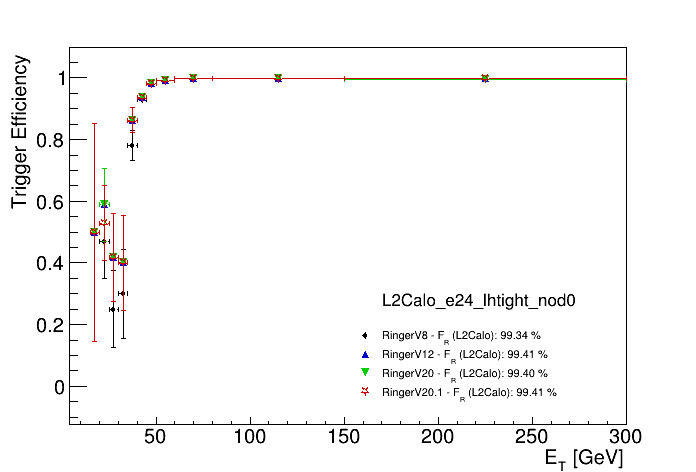

In [16]:
fig.show()